In [2]:
import torch
import pandas as pd
import os
import time
import cv2 as cv
from PIL import Image
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.autograd import Variable

## 参数

In [3]:
photo_path = './data/photo_jpg'
monet_path = './data/monet_jpg'

BATCH_SIZE = 2
LR_RATE = 1E-3

## 查看图片

### 原图

In [4]:
img_names = [name for name in list(filter(lambda x: x.endswith(".jpg"), 
                                                        os.listdir(photo_path)))]
print(img_names[:10])

img_path = os.path.join(photo_path, img_names[1])
print(img_path)

img = Image.open(img_path)
img.show()

['00068bc07f.jpg', '000910d219.jpg', '000ded5c41.jpg', '00104fd531.jpg', '001158d595.jpg', '0033c5f971.jpg', '0039ebb598.jpg', '003aab6fdd.jpg', '003c6c30e0.jpg', '00479e2a21.jpg']
./data/photo_jpg\000910d219.jpg


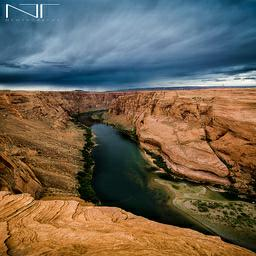

In [5]:
img

In [6]:
# p1 = cv.imread(os.path.join(monet_path, '0a5075d42a.jpg'))
# print(f'p1.shape = {p1.shape}')

# cv.imshow('p1', p1)
# cv.waitKey(0)  #如果不添这一句，在IDLE中执行窗口直接无响应。在命令行中执行的话，则是一闪而过。
# cv.destroyAllWindows()

## 创建数据集

All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

注意数据已经全部缩放到 256x256 尺寸，且已转换为RGB格式，所以我们不需要在进行缩放和转换数据图片格式了，只需要将图片标准化到[-1, 1]即可。另外，由于我们需要构建的是生成式模型，所以我们不需要图片的标签或id，我们只需要返回图片即可。

In [7]:
class MonetDataset(Dataset):
    def __init__(self, data_path, transform):
        
        self.data_path = data_path
        self.transform = transform
        self.img_names = [name for name in list(filter(lambda x: x.endswith(".jpg"), 
                                                        os.listdir(self.data_path)))]

    def __getitem__(self, index):
        img_path = os.path.join(self.data_path, self.img_names[index])
        img = Image.open(img_path).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        if len(self.img_names) == 0:
            raise Exception(f"\ndata_path: {self.data_path} is an empty dir! Please checkout your path!")
        return len(self.img_names)

### 获取标准化参数
获取数据的分布情况

In [8]:
# photo_dataset = MonetDataset(photo_path, transform=transforms.ToTensor())
# print(f'len(photo_dataset): {len(photo_dataset)}')
# print(f'photo_dataset[0].shape: {photo_dataset[0].shape}')

# # # 读取数据集
# # train_dataset = datasets.ImageFolder(photo_path,
# #                                       transform=transforms.ToTensor())

# # 计算均值和标准差
# data_loader = DataLoader(photo_dataset, batch_size=1000, shuffle=True)
# mean = 0.
# std = 0.
# n_images = 0
# for batch in data_loader:
#     batch_size = batch.size(0)
#     # 将 batch_size x 3 x H x W 的张量变成 (batch_size x H x W) x 3
#     batch = batch.view(batch_size, batch.size(1), -1)
#     # 计算每个通道上的均值和标准差
#     mean += batch.mean(2).sum(0)
#     std += batch.std(2).sum(0)
#     n_images += batch_size

# # 将均值和标准差除以样本数
# mean /= n_images
# std /= n_images

# print(f"Mean: {mean}")
# print(f"Std: {std}")


In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.4038, 0.4086, 0.3840], std=[0.2219, 0.2027, 0.2198])
    transforms.Lambda(lambda x: (x / 127.5) - 1)
])

photo_dataset = MonetDataset(photo_path, transform)
dataloader_photo = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f'BATCH_SZIE: {BATCH_SIZE}, len(photo_dataset): {len(photo_dataset)}, len(dataloader_photo): {len(dataloader_photo)}')
print(f'photo_dataset[0].shape: {photo_dataset[0].shape}')

monet_dataset = MonetDataset(monet_path, transform)
dataloader_monet = DataLoader(monet_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f'len(monet_dataset): {len(monet_dataset)}, len(dataloader_monet): {len(dataloader_monet)}')
print(f'monet_dataset[0].shape: {monet_dataset[0].shape}')

BATCH_SZIE: 2, len(photo_dataset): 7038, len(dataloader_photo): 3519
photo_dataset[0].shape: torch.Size([3, 256, 256])
len(monet_dataset): 300, len(dataloader_monet): 150
monet_dataset[0].shape: torch.Size([3, 256, 256])


## 构建模型
### GAN线性版

In [10]:
class Generator_linear(nn.Module):
    def __init__(self, latent_dim, img_shape, normalize=True):
        super(Generator_linear, self).__init__()
        self.latent_dim = latent_dim
        self.img_shape = img_shape
        self.normalize = normalize

        def block(in_dim, out_dim):
            layers = [nn.Linear(in_dim, out_dim)]
            if self.normalize:
                layers.append(nn.BatchNorm1d(out_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))

            return layers
    
        self.model = nn.Sequential(
            *block(self.latent_dim, 128),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)

        return img

class Discriminator_linear(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator_linear, self).__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True), #避免神经元死亡，缓解梯度消失
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        score = self.model(img_flat)

        return score

### GAN 卷积神经网络
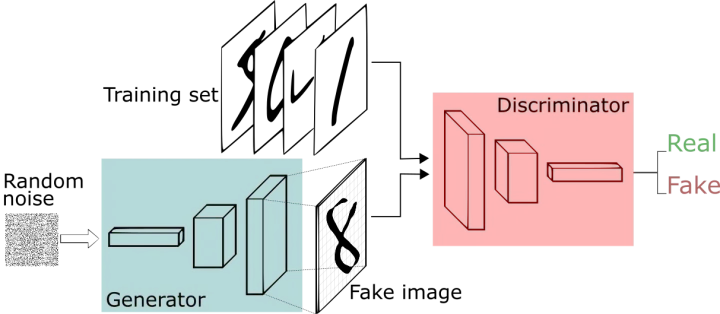

In [11]:
class Down(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.model(x)
    
class Up(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()
        # input: [bs, ]
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True) # inplace会覆盖原内存
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, in_channel):
        super(Discriminator, self).__init__()  
        # input size: [bs, 3, 256, 256], bs = batch size
        self.down1 = Down(in_channel, 64)   # [bs, 64, 128, 128]
        self.down2 = Down(64, 128)          # [bs, 128, 64, 64]
        self.down3 = Down(128, 256)          # [bs, 256, 32, 32]
        self.down4 = Down(256, 512)         # [bs, 512, 16, 16]
        self.down5 = Down(512, 1024)        # [bs, 1024, 8, 8]
        self.down6 = Down(1024, 1024)       # [bs, 1024, 4, 4]

        self.down = nn.Sequential(
            Down(in_channel, 64), # [bs, 64, 128, 128]
            Down(64,  128),       # [bs, 128, 64, 64]
            Down(128, 256),       # [bs, 256, 32, 32]
            Down(256, 512),       # [bs, 512, 16, 16]
            Down(512, 1024),      # [bs, 1024, 8, 8]
            Down(1024, 1024)      # [bs, 1024, 4, 4]
        )

        self.fc = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x1 = self.down1(x)
        # x2 = self.down2(x1)
        # x3 = self.down3(x2)
        # x4 = self.down4(x3)
        # x5 = self.down5(x4)
        # x6 = self.down6(x5)
        # out = self.fc(x6.view(x6.size(0), -1))

        x1 = self.down(x)
        out = self.fc(x1.view(x1.size(0), -1))

        return out

class Generator(nn.Module):
    def __init__(self, latent_dim, num_fea=16384, normalize=True):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.normalize = normalize

        def block(in_dim, out_dim):
            layers = [nn.ConvTranspose2d(in_channels=in_dim, out_channels=out_dim, 
                                         kernel_size=4, stride=2, padding=1)]
            if self.normalize:
                layers.append(nn.BatchNorm2d(out_dim))

            layers.append(nn.ReLU(inplace=True))

            return layers
    
        self.model = nn.Sequential(
            # input: [bs, 1024, 4, 4]
            *block(1024, 512),   # [bs, 512, 8, 8]
            *block(512, 256),    # [bs, 256, 16, 16]
            *block(256, 128),    # [bs, 128, 32, 32]
            *block(128, 64),     # [bs, 64, 64, 64]
            *block(64, 32),      # [bs, 32, 128, 128]
            *block(32, 3)        # [bs, 3, 256, 256]
        )

        self.fc0 = nn.Linear(latent_dim, num_fea)

    def forward(self, z):
        # input: [bs, latent_dim]
        img = self.fc0(z)  # [bs, 16384]
        img = img.view(img.size(0), 1024, 4, 4) # [bs, 1024, 4, 4]
        img = self.model(img)

        return img

In [12]:
x = next(iter(dataloader_monet))
print(f'x.shape: {x.shape}')

dis = Discriminator(3)
res = dis(x)
print(res)
res.shape

x.shape: torch.Size([2, 3, 256, 256])
tensor([[0.6145],
        [0.5489]], grad_fn=<SigmoidBackward0>)


torch.Size([2, 1])

In [14]:
bs = 4
z = torch.randn(bs, 100)
print(f'z.shape = {z.shape}')

G = Generator(100)
z2 = G(z)
z2.shape

z.shape = torch.Size([4, 100])


torch.Size([4, 3, 256, 256])

## 训练模型

In [11]:
img_shape = tuple(photo_dataset[0].shape)
print(f'img_shape: {img_shape}')

latent_dim = 100
normalize_flag = True
EPOCHS = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# Loss function
adversarial_loss = nn.BCELoss()

generator = Generator(latent_dim, img_shape, normalize_flag)
discriminator = Discriminator(img_shape)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=LR_RATE)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=LR_RATE)

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

img_shape: (3, 256, 256)
Device: cuda


### 先试试生成莫奈风格图片吧，在做风格迁移

GAN（Generative Adversarial Network）是一种深度学习模型，用于生成类似于真实数据的新样本。GAN模型由两部分组成：生成器（generator）和判别器（discriminator）。生成器的作用是生成类似于真实数据的新样本，而判别器的作用是区分真实数据和生成器生成的假数据。这两部分分别通过反向传播来进行训练。

GAN的训练过程可以概括为以下步骤：

1. 随机生成一批噪声向量作为生成器的输入；

2. 生成器使用输入噪声向量生成一批假数据；

3. 将假数据和真实数据一起送入判别器进行判别；

4. 判别器根据输入数据的真假情况进行输出，生成器根据判别器的输出来更新自己的权重参数；

重复以上步骤，直到生成器可以生成出足够逼真的假数据为止。

在训练的过程中，生成器和判别器相互博弈，不断优化自己的性能，最终达到一个平衡点，使得生成器可以生成足够逼真的假数据，而判别器也无法再将真实数据和假数据区分出来。

In [12]:
for epoch in range(EPOCHS):
    for i, imgs in enumerate(dataloader_monet):
        
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        
        real_imgs = Variable(imgs.type(Tensor))
        
        # Train Generator
        optimizer_G.zero_grad()
        
        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 3, (imgs.shape[0], latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)
        
        # loss
        aa = discriminator(gen_imgs)
        g_loss = adversarial_loss(aa, valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        
        bb = discriminator(real_imgs)
        real_loss = adversarial_loss(bb, valid)

        # Measure discriminator's ability to classify real from generated samples
        bb = discriminator(real_imgs)
        real_loss = adversarial_loss(bb, valid)
        # 此处需要注意，detach()是为了截断梯度流，不计算生成网络的损失，
        # 因为d_loss包含了fake_loss，回传的时候如果不做处理，默认会计算generator的梯度，
        # 而这里只需要计算判别网络的梯度，更新其权重值，生成网络保持不变即可。
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, EPOCHS, i, len(dataloader_monet), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader_monet) + i
        if batches_done % 10 == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB (GPU 0; 2.00 GiB total capacity; 1.51 GiB already allocated; 0 bytes free; 1.52 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# # zz = generator.model(z)
# print(f'zz.shape: {zz.shape}')
# print(zz.size(0))
# print(generator.img_shape)

# zz2 = zz.view(zz.size(0), *generator.img_shape)
# zz2.shape

# gen_imgs = generator(z)
# gen_imgs

In [ ]:
# import argparse
# import os
# import numpy as np
# import math

# # import torchvision.transforms as transforms
# from torchvision.utils import save_image

# from torch.utils.data import DataLoader
# from torchvision import datasets, models, transforms
# from torch.autograd import Variable

# import torch.nn as nn
# import torch.nn.functional as F
# from tools.my_dataset import myDataset
# import torch

# os.makedirs("images", exist_ok=True)

# parser = argparse.ArgumentParser()
# parser.add_argument("--n_epochs", type=int, default=50, help="number of epochs of training")
# parser.add_argument("--batch_size", type=int, default=2, help="size of the batches")
# parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
# parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
# parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
# parser.add_argument("--n_cpu", type=int, default=4, help="number of cpu threads to use during batch generation")
# parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
# parser.add_argument("--img_size", type=int, default=128, help="size of each image dimension")
# parser.add_argument("--channels", type=int, default=3, help="number of image channels")
# parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")
# opt = parser.parse_args()
# print(opt)

# img_shape = (opt.channels, opt.img_size, opt.img_size)

# cuda = True if torch.cuda.is_available() else False
# print('cuda is',cuda)


# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()

#         def block(in_feat, out_feat, normalize=True):
#             layers = [nn.Linear(in_feat, out_feat)]
#             if normalize:
#                 layers.append(nn.BatchNorm1d(out_feat, 0.8))
#             layers.append(nn.LeakyReLU(0.2, inplace=True))
#             return layers

#         self.model = nn.Sequential(
#             *block(opt.latent_dim, 128, normalize=False),
#             *block(128, 256),
#             *block(256, 512),
#             *block(512, 1024),
#             nn.Linear(1024, int(np.prod(img_shape))),
#             nn.Tanh()
#         )

#     def forward(self, z):
#         img = self.model(z)
#         img = img.view(img.size(0), *img_shape)
#         return img


# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()

#         self.model = nn.Sequential(
#             nn.Linear(int(np.prod(img_shape)), 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(256, 1),
#             nn.Sigmoid(),
#         )

#     def forward(self, img):
#         img_flat = img.view(img.size(0), -1)
#         validity = self.model(img_flat)

#         return validity


# # Loss function
# adversarial_loss = torch.nn.BCELoss()

# # Initialize generator and discriminator
# generator = Generator()
# discriminator = Discriminator()

# if cuda:
#     generator.cuda()
#     discriminator.cuda()
#     adversarial_loss.cuda()

# dataset = r'E:\Projects\gan\battery'
# ng_directory = os.path.join(dataset, 'ng')
# ok_directory = os.path.join(dataset, 'ok')

# image_transforms = {
#     'ng': transforms.Compose([
#         transforms.Resize([opt.img_size,opt.img_size]),
#         transforms.ToTensor(),
#         ]),

#     'ok': transforms.Compose([
#         transforms.Resize([opt.img_size,opt.img_size]),
#         transforms.ToTensor(),
#        ])}

# data = {
#     'ng': myDataset(data_dir=ng_directory, transform=image_transforms['ng']),
#     'ok': myDataset(data_dir=ok_directory, transform=image_transforms['ok'])
# }

# dataloader = DataLoader(data['ng'], batch_size=opt.batch_size, shuffle=True)
# ng_data_size = len(data['ng'])
# ok_data_size = len(data['ok'])
# print('train_size: {:4d}  valid_size:{:4d}'.format(ng_data_size, ok_data_size))
# # Optimizers
# optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))


# Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# # ----------
# #  Training
# # ----------

# for epoch in range(opt.n_epochs):
#     # for i, (imgs, _) in enumerate(dataloader):
#     for i, imgs in enumerate(dataloader):

#         # Adversarial ground truths
#         valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
#         fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

#         # Configure input
#         real_imgs = Variable(imgs.type(Tensor))

#         # -----------------
#         #  Train Generator
#         # -----------------

#         optimizer_G.zero_grad()

#         # Sample noise as generator input
#         z = Variable(Tensor(np.random.normal(0, 3, (imgs.shape[0], opt.latent_dim))))

#         # Generate a batch of images
#         gen_imgs = generator(z)

#         # Loss measures generator's ability to fool the discriminator
#         aa = discriminator(gen_imgs)
#         g_loss = adversarial_loss(aa, valid)

#         g_loss.backward()
#         optimizer_G.step()

#         # ---------------------
#         #  Train Discriminator
#         # ---------------------

#         optimizer_D.zero_grad()

#         # Measure discriminator's ability to classify real from generated samples
#         bb = discriminator(real_imgs)
#         real_loss = adversarial_loss(bb, valid)
#         # 此处需要注意，detach()是为了截断梯度流，不计算生成网络的损失，
#         # 因为d_loss包含了fake_loss，回传的时候如果不做处理，默认会计算generator的梯度，
#         # 而这里只需要计算判别网络的梯度，更新其权重值，生成网络保持不变即可。
#         fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
#         d_loss = (real_loss + fake_loss) / 2

#         d_loss.backward()
#         optimizer_D.step()

#         print(
#             "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
#             % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
#         )

#         batches_done = epoch * len(dataloader) + i
#         if batches_done % opt.sample_interval == 0:
#             save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)



## 参考资料：
[1] [用GAN训练自己的数据生成新的图片](https://blog.csdn.net/qq_36563273/article/details/119325318) <br>
[2] [Monet CycleGAN Tutorial](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial#Introduction-and-Setup) <br>
[3] [比赛官网](https://www.kaggle.com/competitions/gan-getting-started/overview) <br>
[4] [GANs入门系列之（二）用GAN生成MNIST数据集之pytorch实现](https://blog.csdn.net/weixin_41278720/article/details/80861284?depth_1-)